# Bank Telemarketing Prediction

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be (or not) subscribed.

The classification goal is to predict if the client will subscribe a term deposit (variable y).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(style="darkgrid")

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix

import shap
shap.initjs()

# Function for displaying all columns
def display_all(df):
    with pd.option_context("display.max_rows", 1000): 
        with pd.option_context("display.max_columns", 1000): 
            display(df)
            
# Function for plotting the confusion matrix
def plot_confusion_matrix(cnf_mtx, model_name='Model'):
    fig, ax = plt.subplots(figsize=(6, 6))
    title = model_name + ' Confusion Matrix'
    ax = sns.heatmap(cnf_mtx, annot=True, fmt="d", cbar=False, cmap='Blues', square=True)
    ax = ax.set(title=title, xlabel='Predicted Label', ylabel='True Label')

# Function for plotting ROC with AUC
def plot_roc_curve(actuals, probs, model_name='Model'):
    """ Function takes actual Y labels and prediciton probabilities for 
        both classes. Function uses these to plot ROC-curves and AUC.
    """
    # Calculating true and false positive rates
    fpr, tpr, _ = roc_curve(actuals.values.ravel(), probs[:,1])
    
    # Calculating AUC
    auc = roc_auc_score(actuals.values.ravel(), probs[:,1])
    
    # Create plot legend with AUC metric
    label = model_name + ', AUC: %.3f' % auc
    
    # Plot the roc curve for the model
    plt.figure(figsize=(10,10))
    plt.plot(fpr, tpr, label=label)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

In [2]:
df = pd.read_csv('data/bank-full.csv', sep=';')
df.head(20)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
5,35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no
6,28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,-1,0,unknown,no
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,380,1,-1,0,unknown,no
8,58,retired,married,primary,no,121,yes,no,unknown,5,may,50,1,-1,0,unknown,no
9,43,technician,single,secondary,no,593,yes,no,unknown,5,may,55,1,-1,0,unknown,no


In [3]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
age          45211 non-null int64
job          45211 non-null object
marital      45211 non-null object
education    45211 non-null object
default      45211 non-null object
balance      45211 non-null int64
housing      45211 non-null object
loan         45211 non-null object
contact      45211 non-null object
day          45211 non-null int64
month        45211 non-null object
duration     45211 non-null int64
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null object
y            45211 non-null object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


## Inspecting and Encoding Variables

no     39922
yes     5289
Name: y, dtype: int64


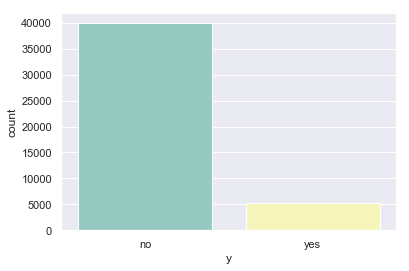

In [5]:
plt.figure(figsize=(6,4))
sns.countplot(x="y", data=df, palette="Set3");
print(df.y.value_counts())

As we can see the target class is highly unbalanced and we need to take this into account when fitting algorithms. This can be dealt either by sampling or stratifying the data when it is split into train-validation-test sets.

In [6]:
# Checking value counts of binary variables
print(df.default.value_counts())
print(df.housing.value_counts())
print(df.loan.value_counts())
print(df.y.value_counts())

no     44396
yes      815
Name: default, dtype: int64
yes    25130
no     20081
Name: housing, dtype: int64
no     37967
yes     7244
Name: loan, dtype: int64
no     39922
yes     5289
Name: y, dtype: int64


In [7]:
# Replacing binary variables no and yes with 0 and 1
df.replace({'no':0, 'yes':1}, inplace=True)

print(df.default.value_counts())
print(df.housing.value_counts())
print(df.loan.value_counts())
print(df.y.value_counts())

0    44396
1      815
Name: default, dtype: int64
1    25130
0    20081
Name: housing, dtype: int64
0    37967
1     7244
Name: loan, dtype: int64
0    39922
1     5289
Name: y, dtype: int64


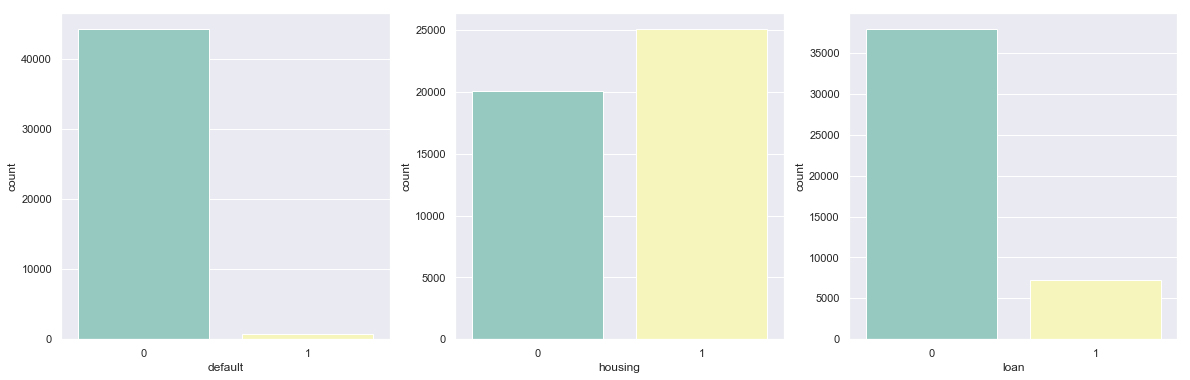

In [8]:
# Binary variable distributions
binary = ['default', 'housing', 'loan']

plt.figure(figsize=(20,6))
for i in range(1, 4):
    plt.subplot(1, 3, i)
    sns.countplot(x=binary[i-1], data=df, palette="Set3")
plt.show()

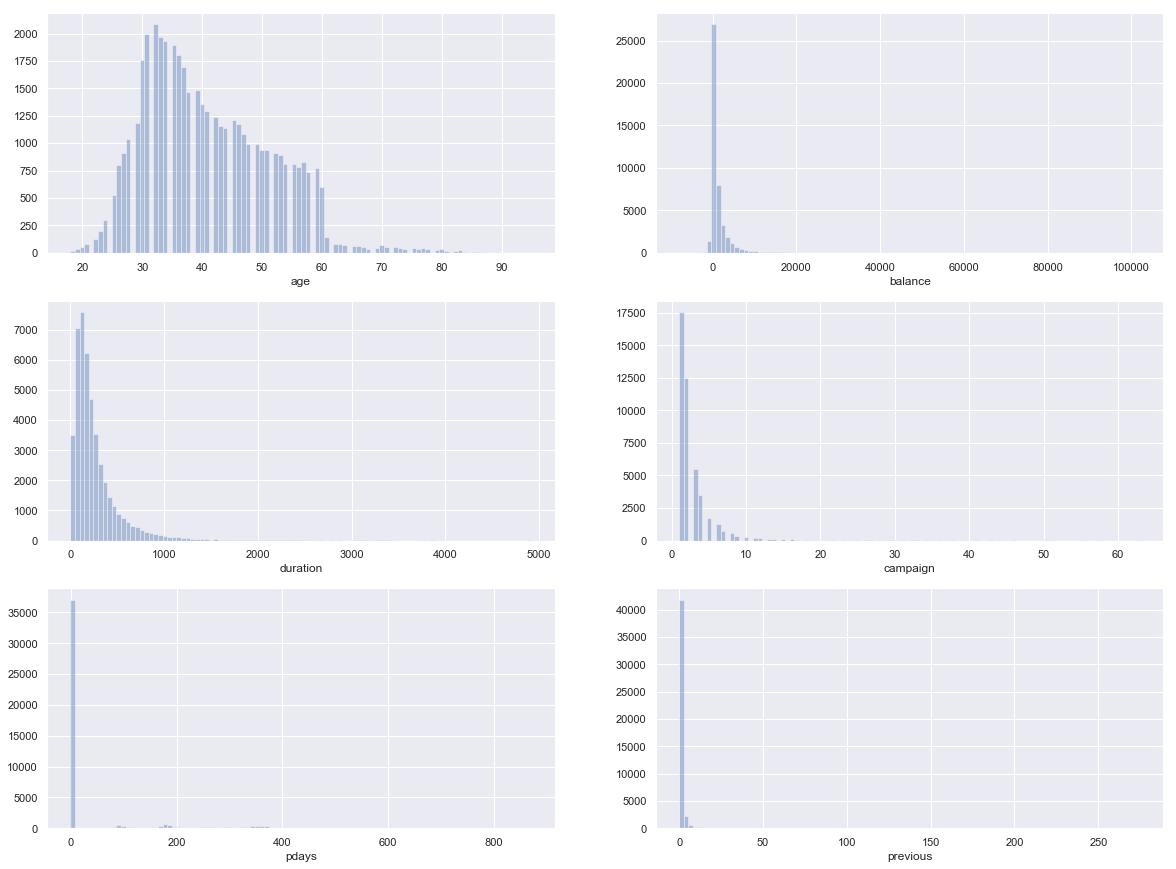

In [9]:
# Continuous feature distributions
continuous = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']

plt.figure(figsize=(20, 15))
for i in range(1, 7):
    plt.subplot(3, 2, i)
    sns.distplot(df[continuous[i-1]], bins=100, kde=False)
plt.show()

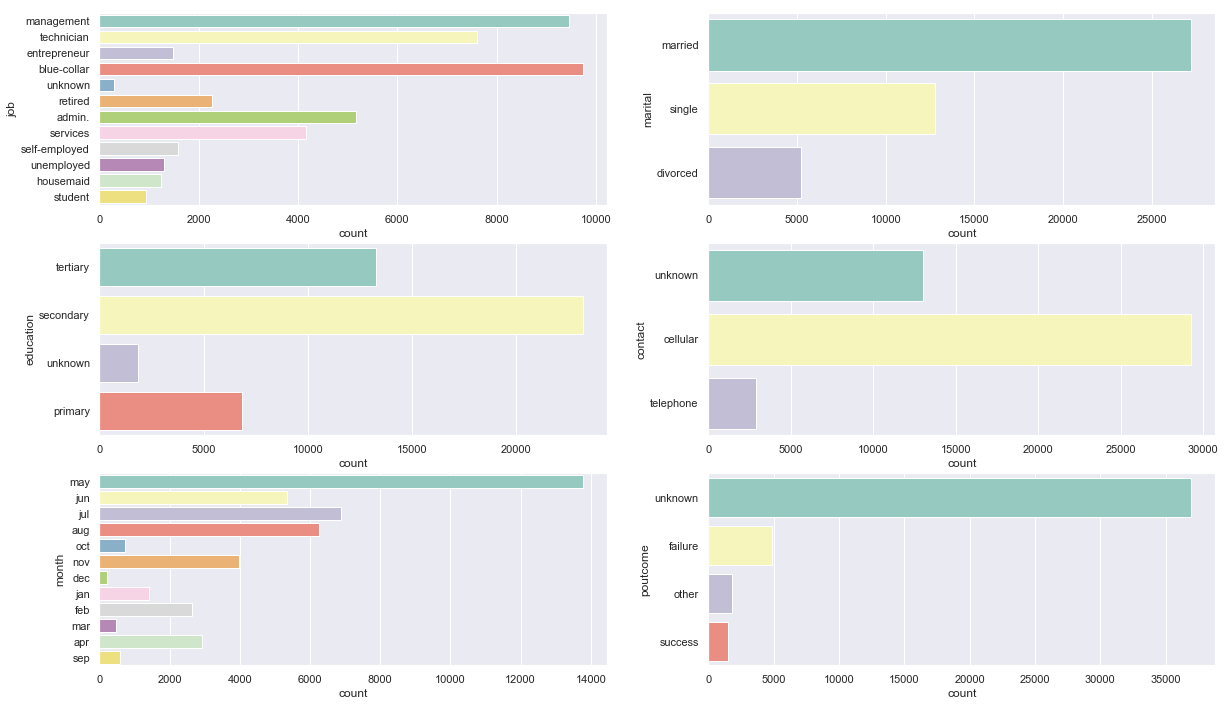

In [10]:
# # Categorical feature distributions
nominal = (df.dtypes == 'object')
nominal_cols = nominal[nominal].index

plt.figure(figsize=(20,12))
for i in range(1, 7):
    plt.subplot(3, 2, i)
    sns.countplot(y=nominal_cols[i-1], data=df, palette="Set3")
plt.show()

In [11]:
# Getting dummy variables of all nominal variables
df = pd.get_dummies(df, columns = nominal_cols)
print(df.shape)

(45211, 49)


In [12]:
display_all(df.head(10).transpose())

,0,1,2,3,4,5,6,7,8,9
age,58,44,33,47,33,35,28,42,58,43
default,0,0,0,0,0,0,0,1,0,0
balance,2143,29,2,1506,1,231,447,2,121,593
housing,1,1,1,1,0,1,1,1,1,1
loan,0,0,1,0,0,0,1,0,0,0
day,5,5,5,5,5,5,5,5,5,5
duration,261,151,76,92,198,139,217,380,50,55
campaign,1,1,1,1,1,1,1,1,1,1
pdays,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
previous,0,0,0,0,0,0,0,0,0,0


Encoding nominal (categorical) variables with numerical values turned 17 variables into 49 variables.

In [13]:
# Writing processed df to csv
df.to_csv('data/full-preprocessed.csv', index=False)

## Train-Validation-Test Split

Splitting data into following sets: test (70%), validation (15%) and test (15%)

In [14]:
from sklearn.model_selection import train_test_split

df = pd.read_csv('data/full-preprocessed.csv')
display_all(df.head(10).transpose())

,0,1,2,3,4,5,6,7,8,9
age,58,44,33,47,33,35,28,42,58,43
default,0,0,0,0,0,0,0,1,0,0
balance,2143,29,2,1506,1,231,447,2,121,593
housing,1,1,1,1,0,1,1,1,1,1
loan,0,0,1,0,0,0,1,0,0,0
day,5,5,5,5,5,5,5,5,5,5
duration,261,151,76,92,198,139,217,380,50,55
campaign,1,1,1,1,1,1,1,1,1,1
pdays,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
previous,0,0,0,0,0,0,0,0,0,0


In [15]:
# Splitting dataframe into target variable y and features X
y = df.pop('y')
X = df
print(X.shape, y.shape)

(45211, 48) (45211,)


In [16]:
# Splitting the original set twice to get train, validation and test sets
trainX, tempX, trainY, tempY = train_test_split(X, y, test_size=0.3, random_state=42)

validX, testX, validY, testY = train_test_split(tempX, tempY, test_size=0.5, random_state=42)

print(trainX.shape, trainY.shape, validX.shape, validY.shape, testX.shape, testY.shape)

(31647, 48) (31647,) (6782, 48) (6782,) (6782, 48) (6782,)


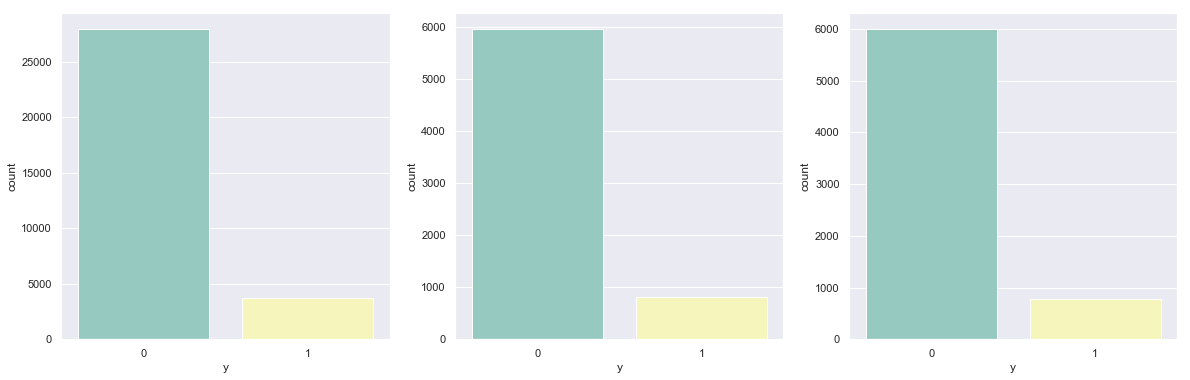

In [17]:
# Checking that target variables are equally distributed in each set
sets = [trainY, validY, testY]

plt.figure(figsize=(20,6))
for i in range(1, 4):
    plt.subplot(1, 3, i)
    sns.countplot(x=sets[i-1], data=df, palette="Set3")
plt.show()

In [18]:
# Writing each set to their own files
trainX.to_csv('data/trainX.csv', index=False)
trainY.to_csv('data/trainY.csv', index=False, header=['y'])
validX.to_csv('data/validX.csv', index=False)
validY.to_csv('data/validY.csv', index=False, header=['y'])
testX.to_csv('data/testX.csv', index=False)
testY.to_csv('data/testY.csv', index=False, header=['y'])

## Balanced Training Set

Oversampling dataset with synthetic minor oversamplig (SMOTE) to avoid classifiers being biased towards majority class. Classification using class-imbalanced data is biased in favor of the majority class.

In [26]:
from imblearn.over_sampling import SMOTE

# Extracting column names
col_names = df.columns

(55912, 48) (55912,)


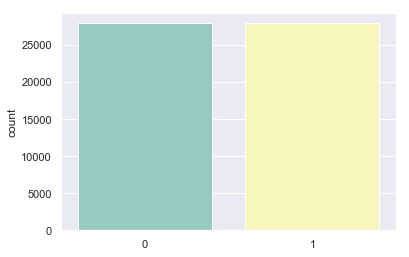

In [28]:
# Oversampling minority class with SMOTE
smote = SMOTE(sampling_strategy='minority', random_state=42)
resampledX, resampledY = smote.fit_resample(trainX, trainY.values.ravel())

# Turning numpy arrays resulted from SMOTE into dataframes
resampledX = pd.DataFrame(resampledX, columns=col_names)
resampledY = resampledY.ravel()

sns.countplot(resampledY, palette="Set3");
print(resampledX.shape, resampledY.shape)

# Turning Y array into dataframe before storing
resampledY = pd.DataFrame(resampledY)

In [29]:
# Writing each set to their own files
resampledX.to_csv('data/balanced_trainX.csv', index=False)
resampledY.to_csv('data/balanced_trainY.csv', index=False, header=['y'])

## Model Comparison

In [1]:
# Reading data 
balanced_trainX = pd.read_csv('data/balanced_trainX.csv')
balanced_trainY = pd.read_csv('data/balanced_trainY.csv')
validX = pd.read_csv('data/validX.csv')
validY = pd.read_csv('data/validY.csv')

print(balanced_trainX.shape, balanced_trainY.shape, validX.shape, validY.shape)
display_all(balanced_trainX.head(10).transpose())

NameError: name 'pd' is not defined

In [2]:
def multiple_classifier_auc(classifiers, trainX, trainY, validX, validY):
    """
    Function takes a list of classifiers as a list with train and validation sets.
    
    Function returns results (fpr, tpr and auc) as a dataframe.
    """
    
    # Define a result table as a DataFrame
    results = pd.DataFrame(columns=['classifier', 'fpr','tpr','auc'])

    # Train the models and record the results
    for clf in classifiers:
        model = clf.fit(trainX, trainY.values.ravel())
        probs = model.predict_proba(validX)[:,1]

        fpr, tpr, _ = roc_curve(validY, probs)
        auc = roc_auc_score(validY, probs)

        results = results.append({'classifier':clf.__class__.__name__,
                                            'fpr':fpr, 
                                            'tpr':tpr, 
                                            'auc':auc}, ignore_index=True)

    # Set name of the classifiers as index labels and return dataframe
    results.set_index('classifier', inplace=True)
    return results

def plot_multiple_classifier_roc(results):
    """
    Function takes results table from multiple_classifier_roc function
    and makes single plot for comparing different models.
    """

    fig = plt.figure(figsize=(16,14))

    for i in results.index:
        plt.plot(results.loc[i]['fpr'], 
                 results.loc[i]['tpr'], 
                 label="{}, AUC={:.3f}".format(i, results.loc[i]['auc']))

    plt.plot([0,1], [0,1], color='orange', linestyle='--')

    plt.xticks(np.arange(0.0, 1.1, step=0.1))
    plt.xlabel("False Positive Rate", fontsize=15)

    plt.yticks(np.arange(0.0, 1.1, step=0.1))
    plt.ylabel("True Positive Rate", fontsize=15)

    plt.title('ROC Curve Comparison', fontweight='bold', fontsize=15)
    plt.legend(prop={'size':13}, loc='lower right')

    plt.show()

In [ ]:
# Instantiate the classfiers with best parameters tried out
classifiers = [LogisticRegression(solver='lbfgs', random_state=42, n_jobs=-1),
               DecisionTreeClassifier(max_depth=20,  min_samples_leaf=10, min_samples_split=120, random_state=42),
               RandomForestClassifier(n_estimators=1000, max_depth=20, min_samples_split=10, min_samples_leaf=1, random_state=42, n_jobs=-1),
               lgb.LGBMClassifier(random_state=42, n_jobs=-1)]

# Train and validate different 
results = multiple_classifier_auc(classifiers, balanced_trainX, balanced_trainY, validX, validY)

# Plot classifier performances
plot_multiple_classifier_roc(results)

Based on each model's performance on the validation set we chose LightGBM for final performance assesment.

## Feature Selection with SHAP

In [ ]:
lgb_model = lgb.LGBMClassifier(random_state=42, n_jobs=-1)
lgb_model = lgb_model.fit(balanced_trainX, balanced_trainY.values.ravel())

# Explain model predictions using shap library:
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(validX)

In [ ]:
# Plot summary_plot, feature importances of top 20 features in predicting class 1
shap.summary_plot(shap_values[1], validX)
plt.show()

We can also just take the mean absolute value of the SHAP values for each feature to get a standard bar plot (produces stacked bars for multi-class outputs):

In [ ]:
shap.summary_plot(shap_values, validX, plot_type="bar")

In [ ]:
# Get important features based on shap values
shap_sum = np.abs(shap_values[1]).mean(axis=0)
importances = pd.DataFrame([balanced_trainX.columns.tolist(), shap_sum.tolist()]).T
importances.columns = ['column_name', 'shap_importance']
importances = importances.sort_values('shap_importance', ascending=False)
display_all(importances.head(50))

## Final Testing and Interpreting Model Output with SHAP